# A quanvolutional neural network

This tutorial will demonstrate a basic quantum-enhanced neural network a _quanvolutional neural network_. Unlike a conventional convolutional customization, the quanvolutional kernel uses qubits for each pixel of the kernel, and the output is the measurements after applying quantum gates to kernel qubits and possibly extra qubits.

The layers used are there only to demonstrate the potential strengths of a quantum convolutional layer, even if the layer is not trainable. Much better optimized layers exist for the classification of MNIST, which can show potential of further improvement when certain conventional layers are replaced with quantum layers.

## Prerequisites

We will use Tensorflow as our machine learning library. Pennylane, as `qml`, contains its own version of `numpy` packages. Additionally, you may have to use a "downdated" version of Python, namely Python 3.9, so it is compatible with `tensorflow-quantum`.

### Required libraries

* `pennylane`
* `tensorflow` with `keras`
* `matplotlib`

Failing to import all the packages will result in an ImportError. Additionaly steps might be required to add GPU support.

### Experience

This tutorial is considerably involved, and requires the knowledge of applying custom Keras layers and leveraging parallelism whenever possible in addition to basic Pennylane knowledge. The only code segments involving Pennylane is the implementation of the quanvolutional gate.

Outputs are displayed using Matplotlib.

### How to run

The user has the ability to adjust the size of the convolutional kernel $K$ and the number of output layers $L$. The user also has the option to set the number of epochs, size of datasets, batch size, and display options. The sizes of the images must be consistent for this to work.

If GPU acceleration is enabled, the GPU will provide substantial speedups in the models, except for the trainable quanvolutional model. You can enable GPU acceleration on both the Pennylane side (`lightning-gpu`) and on Tensorflow side.

In [1]:
# Import Pennylane libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

# Import Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer

# Import Matplotlib
import matplotlib.pyplot as plt

# Auxiliary
from multiprocessing.pool import ThreadPool

# GPU acceleration options
print("GPUs: ", tf.config.list_physical_devices('GPU'))
print("Eager execution: ", tf.executing_eagerly())

2024-08-29 21:02:33.330223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 21:02:33.341248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 21:02:33.344483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 21:02:33.354952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 21:02:34.603227: W ten

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution:  True


## Set up dataset and hyperparameters

The deep learning model consists of a convolutional layer (ran both classically and quantumly) and pooling. In the original model, the quanvolutional layer is non-trainable. There is no activation layer after the classical and quantum layers. The loss function is the sparse categorical cross-entropy, and Adam (meaning "Adaptive Moment Estimation") will be the optimizer.

### Hyperparameters

The model will only use one convolutional layer using a square convolutional kernel. The kernel can be adjusted by the size $K$ and the number of layers $L$.

* $K$, the dimension of the square kernel
* $L$, the number of layers of the kernel

### Iteration, batch size, and dataset

You are also able to adjust the number of epochs and the batch size of the training run. You can also reduce the number of images of the training dataset.

In [2]:
# Convolution
n_channels =  11                 # Number of random channels
kernel_size = 3                  # Size of kernel

# Epochs
n_epochs = 100                  # Number of optimization epochs
n_train = 1024                  # Size of the train dataset
n_valid = 32                    # Size of the validation dataset (not used)
n_test = 128                    # Size of the test dataset
batch_size = 16                 # Batch size, the sub-dataset used for the training per iteration
device = 'lightning.gpu'        # 'lightning-gpu' for GPU acceleration

# Dataset
SAVE_PATH = "./mnist"           # Data saving folder
PREPROCESS = True               # If False, skip quantum processing and load data from SAVE_PATH
SETSEED = False
if SETSEED:
    np.random.seed(0)           # Seed for NumPy random number generator
    tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Dataset and image size
DATASET = keras.datasets.mnist # Default dataset
(train_images, train_labels), (test_images, test_labels) = DATASET.load_data() # Load data (returns a pair of image-label pairs)
HEIGHT = 28
LENGTH = 28
LABELS = 10

# Reduce dataset size to the first few
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Output of this cell is the size of the initial tensor
print("Size of initial tensor: {0:s}".format(str(train_images[0].shape)))
train_images[0]

Size of initial tensor: (28, 28, 1)


tensor([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         

## Quantum circuit

In a quantum convolutional network, the convolutional kernel is a quantum circuit. The orderings of the gate operations become one quanvolutional filter in the quanvolutional layer. A _random_ quantum convolutional filter is used, described using $LK^2$ parameters.

tensor([[5.17143486, 2.33323294, 4.59883206],
        [5.38045581, 2.51316187, 0.74148902],
        [1.66646843, 5.93165274, 5.20738349]], requires_grad=True)

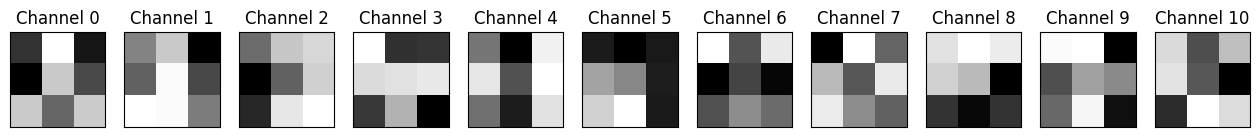

In [3]:
# Set up random paramaters, which will then be the trainable weights of the quanvolutional kernel
rand_params = np.random.uniform(high=2 * np.pi, size=(n_channels, kernel_size*kernel_size))
rand_params # A L × K² tensor

# Output is to print and display these random parameters
fig, axes = plt.subplots(1, n_channels, figsize=(16, 16))
for k in range(n_channels):
    axes[k].set_title("Channel {0:d}".format(k))
    axes[k].xaxis.set_visible(False)
    axes[k].yaxis.set_visible(False)
    axes[k].imshow(rand_params[k].reshape([kernel_size,kernel_size]), cmap="gray") # Lighter indicate higher value
rand_params[k].reshape([kernel_size,kernel_size])

### Circuit implementation

The quantum circuit will be the convolutional and pooling layer. For each channel and pixel, the circuit consists of $K^2$ qubit wires, with each wire representing a particular neighboring cell used for the pixel. The inputs of the convolutional filter is passed through a RY gate, and the entire circuit is operated by a RandomLayer described by `rand_params`.

We will call this circuit `yrand`, meaning RY then random.

[array(0.00734058), array(0.0091471), array(0.02532161), array(-0.03004029), array(0.02118765), array(0.02507264), array(-0.00178149), array(-0.00044863), array(-0.00934969), array(-0.17899794), array(0.01837279)]


/tmp/ipykernel_36213/3824838043.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # Use qml.draw_mpl to draw out the circuit


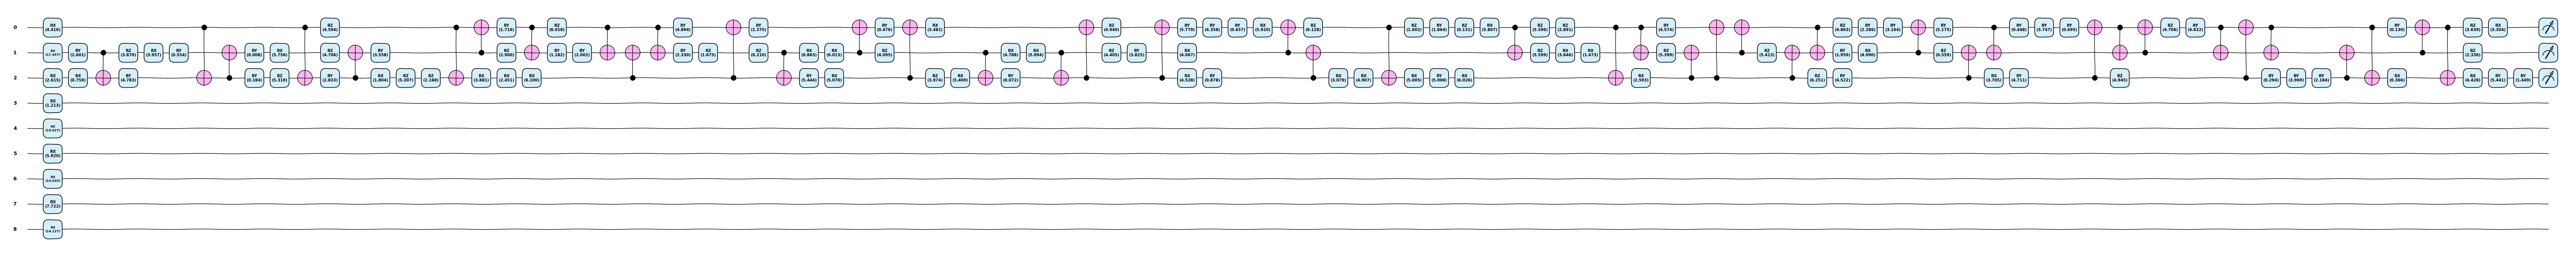

In [4]:
PARALLEL = 1

# Develop quantum circuit
dev = qml.device(device, wires=max(n_channels, kernel_size*kernel_size))
@qml.qnode(dev)
def yrand(n_channels, kernel_size, input, weights=np.random.uniform(high=2 * np.pi, size=(n_channels, kernel_size*kernel_size))):
    # Encoding of classical input values from kernel
    for wire in range(kernel_size*kernel_size):
        qml.RX(np.pi * input[wire], wires=wire)

    # Random quantum circuit
    RandomLayers(weights, wires=list(range(n_channels)))

    # Measurement producing classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_channels)]

# Helpe function for generating convolutional filter
def generatefilter(image, j, k, kernel_size):
    """Lists out the neighboring cells useed for this convolution"""
    filter = []
    for j1 in range(0, kernel_size):
        for k1 in range(0, kernel_size):
            filter.append(image[j + j1, k + k1, 0])
    return filter

# Perform quanvolution on all the cells of an individual image, as a tensor of (L + 1) dimensions
def quanv(qcircuit, n_channels, kernel_size, image, weights):
    """
    Convolves the input image with many applications of the same quantum circuit.
    This is a computationally expensive procedure.
    """
    # We know the dimensions of the output image
    out = np.zeros((HEIGHT//kernel_size, LENGTH//kernel_size, n_channels))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(0, HEIGHT - kernel_size + 1, kernel_size):
        for k in range(0, LENGTH - kernel_size + 1, kernel_size):
            # Perform convolution. This requires tf.numpy_function since you cannot iterate over a symbolic tensor otherwise.
            # q_results = qcircuit(n_channels, kernel_size, generatefilter(image, j, k, kernel_size), weights)
            q_results = tf.numpy_function(func=qcircuit, 
                                          inp=(n_channels, 
                                               kernel_size, 
                                               generatefilter(image, j, k, kernel_size), 
                                               weights), 
                                          Tout=tf.float32)
            # Assign expectation values to different channels of the output pixel as pooling layer
            out[j // kernel_size, k // kernel_size,:] = q_results[:]
    return out

# Perform quanvolution on all the images, as a tensor of (L + 2) dimensions
def quanv_all(qcircuit, n_channels, kernel_size, images, weights):
    """
    Applies the quanvolution operation to all images.
    Unfortunately, the implementation is still loop-based rather than broadcasted.
    Due to the expensive nature of quanv, this method also gives a "progress bar".
    """
    # PARALLEL CPU
    if PARALLEL > 1 and device != 'lightning-gpu':
        out = []
        k = 0
        while k < images.shape[0]:
            with ThreadPool() as P:
                # Quanvolution appears here
                out += P.map(lambda image: quanv(qcircuit, n_channels, kernel_size, image, weights), images[k:k+PARALLEL,])
            k += PARALLEL
        print()
        return np.array(out)
    # SERIAL
    out = np.zeros(((images.shape[0], HEIGHT//kernel_size, LENGTH//kernel_size, n_channels)))
    for k,image in enumerate(images):
        print("Images quanvolved: \t{}/{}".format(k, images.shape[0]), end="\r") # Compuationally expensive
        # Quanvolution appears here
        out[k,:] = quanv(qcircuit, n_channels, kernel_size, image, weights)[:]
        
    print("Images quanvolved: \t{}/{}".format(images.shape[0], images.shape[0])) # Compuationally expensive

    return out

# Output is to sketch out demo circuit
democircuit = yrand(n_channels, kernel_size, generatefilter(test_images[0], 0, 0, kernel_size), rand_params)
print(democircuit) # Print out the circuit
drawer = qml.draw_mpl(yrand, style='pennylane_sketch', decimals=3)
fig, ax = drawer(3, 3, rand_params[0])
fig.show() # Use qml.draw_mpl to draw out the circuit

### Manual Quantum layer

In the first hybrid model, the only quantum step is the quantum preprocessing of trained images. This step is skipped for the classical convolutional algorithm.
Please note this step can take longer, with up to 16 minutes for 512 images.

You can set the boolean `PREPROCESS` to adjust whether to always preprocess the images, or to load the images instead.

In [5]:
if PREPROCESS == True:
    # Quanvolute the images (computationally expensive)
    q_train_images = quanv_all(yrand, n_channels, kernel_size, train_images, rand_params)
    q_test_images = quanv_all(yrand, n_channels, kernel_size, test_images, rand_params)
    # Save the quanvoluted layers
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

# Also manually preprocess the same image set classically
c_train_images = keras.layers.Conv2D(n_channels, kernel_size, activation=None, strides=kernel_size, trainable=False)(train_images)

2024-08-29 21:02:38.061427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2147 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Images quanvolved: 	1024/1024
Images quanvolved: 	128/128


2024-08-29 21:17:20.317008: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1724980640.459945   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.511354   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.512845   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.514448   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.516037   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.546286   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.556036   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980640.557891   36213 gpu_t

### Displaying quantum convolution and pooling.

The following code is a demonstration of applying the quantum convolutional pooling layer. The top row displays the original images. The lower rows displays the conventionally convluted (left) and quanvoluted images (right) respectively. You can set the number of display samples to show by adjusting the positive integer `DISPLAYSAMPLES`.

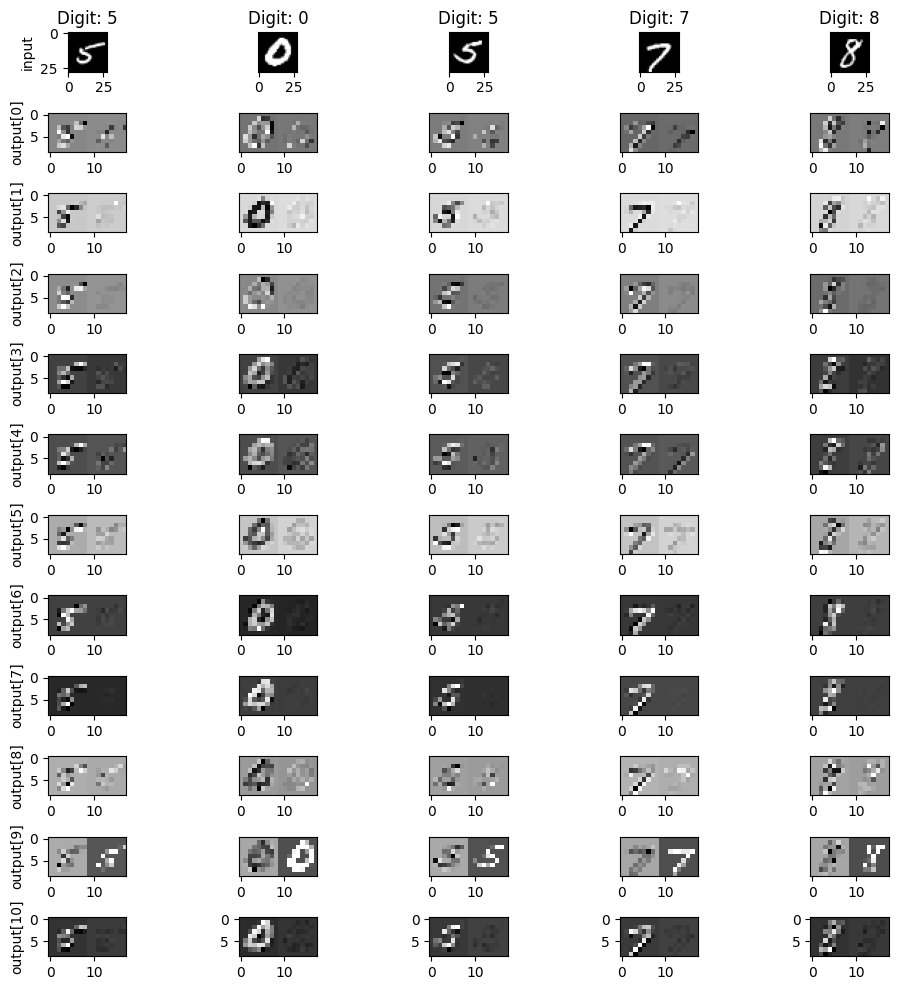

Dimension before quanvolution (128, 28, 28, 1)
Dimension after quanvolution  (128, 9, 9, 11)


In [6]:
DISPLAYSAMPLES = 5
fig, axes = plt.subplots(1 + n_channels, DISPLAYSAMPLES, figsize=(10, 10))

# Column number is the sample used
for k in range(DISPLAYSAMPLES):
    RANDOMINDEX = np.random.randint(len(train_images))
    # Plot input channel
    axes[0, 0].set_ylabel("input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].set_title("Digit: {}".format(train_labels[RANDOMINDEX]))
    axes[0, k].imshow(train_images[RANDOMINDEX, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[1 + c, 0].set_ylabel("output[{}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[1 + c, k].imshow(np.hstack([c_train_images[RANDOMINDEX, :, :, c], q_train_images[RANDOMINDEX, :, :, c]]), cmap="gray")
plt.tight_layout()
plt.show()

# Also provide the dimensions of the entire tensor before and after convolution
print("Dimension before quanvolution {}".format(test_images.shape))
print("Dimension after quanvolution  {}".format(q_test_images.shape))

## Original model

The next two machine learning models use nontrainable layers.

In [7]:
flattenonly = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(LABELS, activation="softmax")
])

convseq = keras.models.Sequential([
		keras.layers.Conv2D(n_channels, kernel_size, activation=None, strides=kernel_size, trainable=False),
        keras.layers.Flatten(),
        keras.layers.Dense(LABELS, activation="softmax")
])

# Define and compile the model, using a sequential model as the input.
def MyModel(model):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""

    model.compile(
        optimizer='adam',
        run_eagerly = True, # Allows embedding quanvolutional circuit as a Keras layer
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Classical

The model only uses the conventional image training preprocessing layer.

In [8]:
c_model = MyModel(convseq)
print(c_model.summary())

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


W0000 00:00:1724980642.251520   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.252925   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.254299   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.255689   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.257088   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.258508   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.259925   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.262210   36213 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724980642.263629   36213 gp

64/64 - 2s - 27ms/step - accuracy: 0.4414 - loss: 2.0009 - val_accuracy: 0.6250 - val_loss: 1.7265
Epoch 2/100
64/64 - 1s - 13ms/step - accuracy: 0.7744 - loss: 1.4409 - val_accuracy: 0.6953 - val_loss: 1.3776
Epoch 3/100
64/64 - 1s - 13ms/step - accuracy: 0.7920 - loss: 1.1264 - val_accuracy: 0.7109 - val_loss: 1.1681
Epoch 4/100
64/64 - 1s - 13ms/step - accuracy: 0.8301 - loss: 0.9378 - val_accuracy: 0.7109 - val_loss: 1.0259
Epoch 5/100
64/64 - 1s - 13ms/step - accuracy: 0.8457 - loss: 0.8134 - val_accuracy: 0.7422 - val_loss: 0.9381
Epoch 6/100
64/64 - 1s - 12ms/step - accuracy: 0.8633 - loss: 0.7278 - val_accuracy: 0.7812 - val_loss: 0.8598
Epoch 7/100
64/64 - 1s - 13ms/step - accuracy: 0.8770 - loss: 0.6621 - val_accuracy: 0.8125 - val_loss: 0.8051
Epoch 8/100
64/64 - 1s - 13ms/step - accuracy: 0.8838 - loss: 0.6103 - val_accuracy: 0.8203 - val_loss: 0.7586
Epoch 9/100
64/64 - 1s - 13ms/step - accuracy: 0.8877 - loss: 0.5699 - val_accuracy: 0.8047 - val_loss: 0.7172
Epoch 10/100


### Hybrid Quantum

The classical convolutional layer is replaced by the quanvolutional layer prescribed by `yrand`.

In [9]:
q_model = MyModel(flattenonly)
print(q_model.summary())
print(q_train_images.shape)

q_history = q_model.fit(
    q_train_images, # Preprocessed
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
(1024, 9, 9, 11)
Epoch 1/100
64/64 - 1s - 12ms/step - accuracy: 0.2627 - loss: 2.2492 - val_accuracy: 0.3516 - val_loss: 2.1564
Epoch 2/100
64/64 - 1s - 11ms/step - accuracy: 0.3564 - loss: 2.1225 - val_accuracy: 0.5312 - val_loss: 2.0598
Epoch 3/100
64/64 - 1s - 11ms/step - accuracy: 0.5879 - loss: 2.0071 - val_accuracy: 0.6406 - val_loss: 1.9647
Epoch 4/100
64/64 - 1s - 11ms/step - accuracy: 0.6807 - loss: 1.9000 - val_accuracy: 0.6641 - val_loss: 1.8778
Epoch 5/100
64/64 - 1s - 11ms/step - accuracy: 0.7051 - loss: 1.7988 - val_accuracy: 0.6797 - val_loss: 1.7975
Epoch 6/100
64/64 - 1s - 12ms/step - accuracy: 0.7354 - loss: 1.7052 - val_accuracy: 0.7031 - val_loss: 1.7230
Epoch 7/100
64/64 - 1s - 11ms/step - accuracy: 0.7422 - loss: 1.6201 - val_accuracy: 0.7422 - val_loss: 1.6579
Epoch 8/100
64/64 - 1s - 11ms/step - accuracy: 0.7852 - loss: 1.5411 - val_accuracy: 0.7734 - val_loss: 1.5881
Epoch 9/100
64/64 - 1s - 11ms/step - accuracy: 0.7998 - loss: 1.4686 - val_accuracy: 0.757

### Graph results

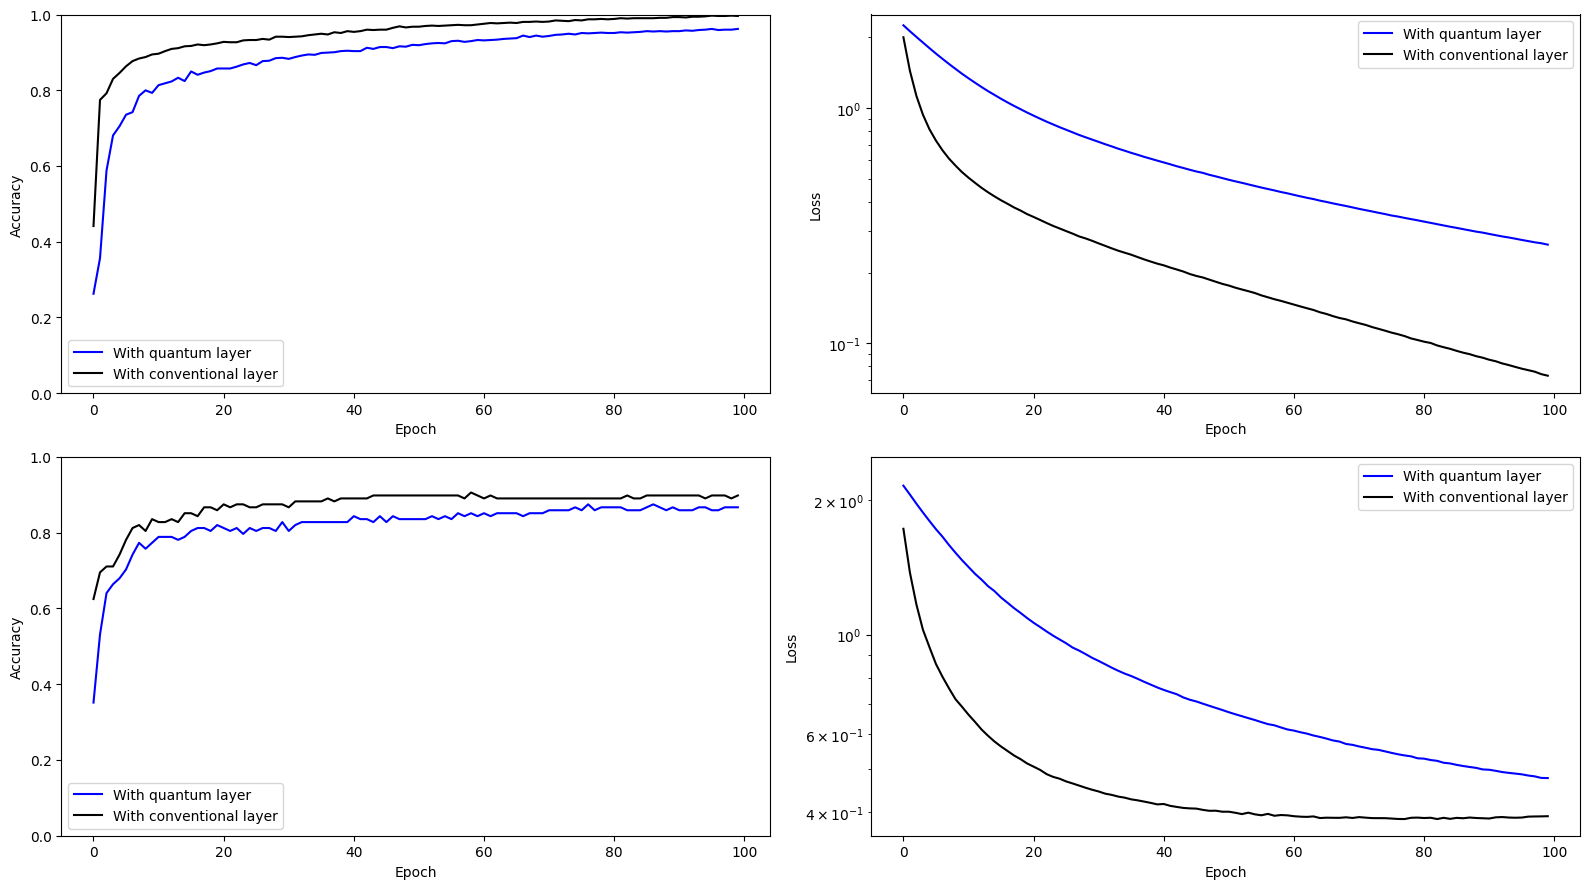

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))

ax1.plot(q_history.history["accuracy"], "-b", label="With quantum layer")
ax1.plot(c_history.history["accuracy"], "-k", label="With conventional layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["loss"], "-b", label="With quantum layer")
ax2.plot(c_history.history["loss"], "-k", label="With conventional layer")
ax2.set_yscale("log")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

ax3.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax3.plot(c_history.history["val_accuracy"], "-k", label="With conventional layer")
ax3.set_ylabel("Accuracy")
ax3.set_ylim([0, 1])
ax3.set_xlabel("Epoch")
ax3.legend()

ax4.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
ax4.plot(c_history.history["val_loss"], "-k", label="With conventional layer")
ax4.set_yscale("log")
ax4.set_ylabel("Loss")
ax4.set_ylim(top=2.5)
ax4.set_xlabel("Epoch")
ax4.legend()

plt.tight_layout()
plt.show()

## Trainable convolutional layer

We repeat the experiment, but this time the convolutional layers are trainable.

### Quanvolutional layer

Pennylane formerly had a feature to convert any quantum circuit into a Keras layer. However, we will build our own Keras layer based on the quanvolutional layer. The output is still obtained by preprocessing the input. This has to be done every iteration or batch, making it very computationally expensive on a simulator.

In [11]:
from keras.src import activations
from keras.src import initializers
from keras.src import ops
from keras.src.layers.layer import Layer
from keras.src.utils.argument_validation import standardize_tuple
from keras.src.ops.operation_utils import compute_conv_output_shape

class Quanv2D(Layer):
    def __init__(self, qcircuit, filters, kernel_size, activation=None, use_bias=True, kernel_initializer="glorot_uniform", bias_initializer="zeros"):
        super().__init__()
        self.qcircuit = qcircuit
        self.filters = filters
        self.rank = 2
        self.kernel_size = (kernel_size, self.rank)
        self.strides = self.kernel_size
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        if self.filters is not None and self.filters <= 0:
            raise ValueError(
                "Invalid value for argument `filters`. Expected a strictly "
                f"positive value. Received filters={self.filters}."
            )
        if not all(self.kernel_size):
            raise ValueError(
                "The argument `kernel_size` cannot contain 0. Received "
                f"kernel_size={self.kernel_size}."
            )

        self.kernel = self.add_weight(
            name="quanvkernel",
            shape=self.kernel_size,
            initializer=self.kernel_initializer,
            # regularizer=self.kernel_regularizer,
            # constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                name="quanvbias",
                shape=(self.filters,),
                initializer=self.bias_initializer,
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.bias = None

    def compute_output_shape(self, input_shape):
        return compute_conv_output_shape(
            input_shape,
            self.filters,
            self.kernel_size,
            strides=self.strides,
        )

    def call(self, inputs):
        outputs = quanv_all(self.qcircuit, self.filters, self.kernel_size[0], inputs, self.kernel)
        print(self.kernel) # Print weights of the kernel
        if self.use_bias:
            bias_shape = (self.filters,)
            bias = ops.reshape(self.bias, bias_shape)
            outputs += bias

        if self.activation is not None:
            return self.activation(outputs)

        return outputs

# Print out the contents of a small segment of the test images after quanvolution.
Quanv2D(yrand, n_channels, kernel_size, activation=None)(test_images[0:10])

Images quanvolved: 	10/10
<KerasVariable shape=(3, 2), dtype=float32, path=quanv2d/quanvkernel>


<tf.Tensor: shape=(10, 9, 9, 11), dtype=float32, numpy=
array([[[[ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         ...,
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ]],

        [[ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        , ...,  0.9635555 ,
           1.        ,  1.   

## Models

We develop and hyperparameterize the models, implemented in Keras.

In [16]:
convseq = keras.models.Sequential([
		keras.layers.Conv2D(n_channels, kernel_size, activation=None, strides=kernel_size, trainable=True),
        keras.layers.Flatten(),
        keras.layers.Dense(LABELS, activation="softmax")
])

quanvseq = keras.models.Sequential([
		Quanv2D(yrand, 2, 2, activation=None),
        keras.layers.Flatten(),
        keras.layers.Dense(LABELS, activation="softmax")
])

c_model = MyModel(convseq)
q_model = MyModel(quanvseq)

### Classical

The model is now trainable.

In [17]:
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

print(c_model.summary())

Epoch 1/100
64/64 - 1s - 18ms/step - accuracy: 0.5283 - loss: 1.8775 - val_accuracy: 0.7500 - val_loss: 1.4168
Epoch 2/100
64/64 - 1s - 17ms/step - accuracy: 0.7979 - loss: 0.9211 - val_accuracy: 0.8203 - val_loss: 0.7640
Epoch 3/100
64/64 - 1s - 17ms/step - accuracy: 0.8516 - loss: 0.5484 - val_accuracy: 0.8359 - val_loss: 0.5614
Epoch 4/100
64/64 - 1s - 17ms/step - accuracy: 0.8818 - loss: 0.4271 - val_accuracy: 0.8672 - val_loss: 0.4675
Epoch 5/100
64/64 - 1s - 17ms/step - accuracy: 0.9033 - loss: 0.3588 - val_accuracy: 0.8750 - val_loss: 0.4239
Epoch 6/100
64/64 - 1s - 17ms/step - accuracy: 0.9072 - loss: 0.3107 - val_accuracy: 0.8672 - val_loss: 0.3879
Epoch 7/100
64/64 - 1s - 17ms/step - accuracy: 0.9229 - loss: 0.2815 - val_accuracy: 0.8750 - val_loss: 0.3754
Epoch 8/100
64/64 - 1s - 17ms/step - accuracy: 0.9297 - loss: 0.2544 - val_accuracy: 0.8750 - val_loss: 0.3369
Epoch 9/100
64/64 - 1s - 17ms/step - accuracy: 0.9385 - loss: 0.2288 - val_accuracy: 0.8984 - val_loss: 0.3148
E

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (16, 9, 9, 11)         │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (16, 891)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (16, 10)               │         8,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,092 (105.83 KB)

 Trainable params: 9,030 (35.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,062 (70.56 KB)

None


### Quanvolutional

This is the highlight of this tutorial! We can see the GPU accelerate both Pennylane and Tensorflow.

In [18]:
q_history = q_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=2,
)

print(q_model.summary())

Epoch 1/100
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images quanvolved: 	16/16
<KerasVariable shape=(2, 2), dtype=float32, path=quanv2d_2/quanvkernel>
Images q

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ quanv2d_2 (Quanv2D)             │ (16, 14, 14, 2)        │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (16, 392)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (16, 10)               │         3,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,810 (46.14 KB)

 Trainable params: 3,936 (15.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,874 (30.76 KB)

None


### Variational circuit (incomplete)

We could make the entire circuit completely quantum by replacing the dense layer with a variational circuit.

### Graph results

This time, we will graph the model performance using a trainable convolutional layer instead.

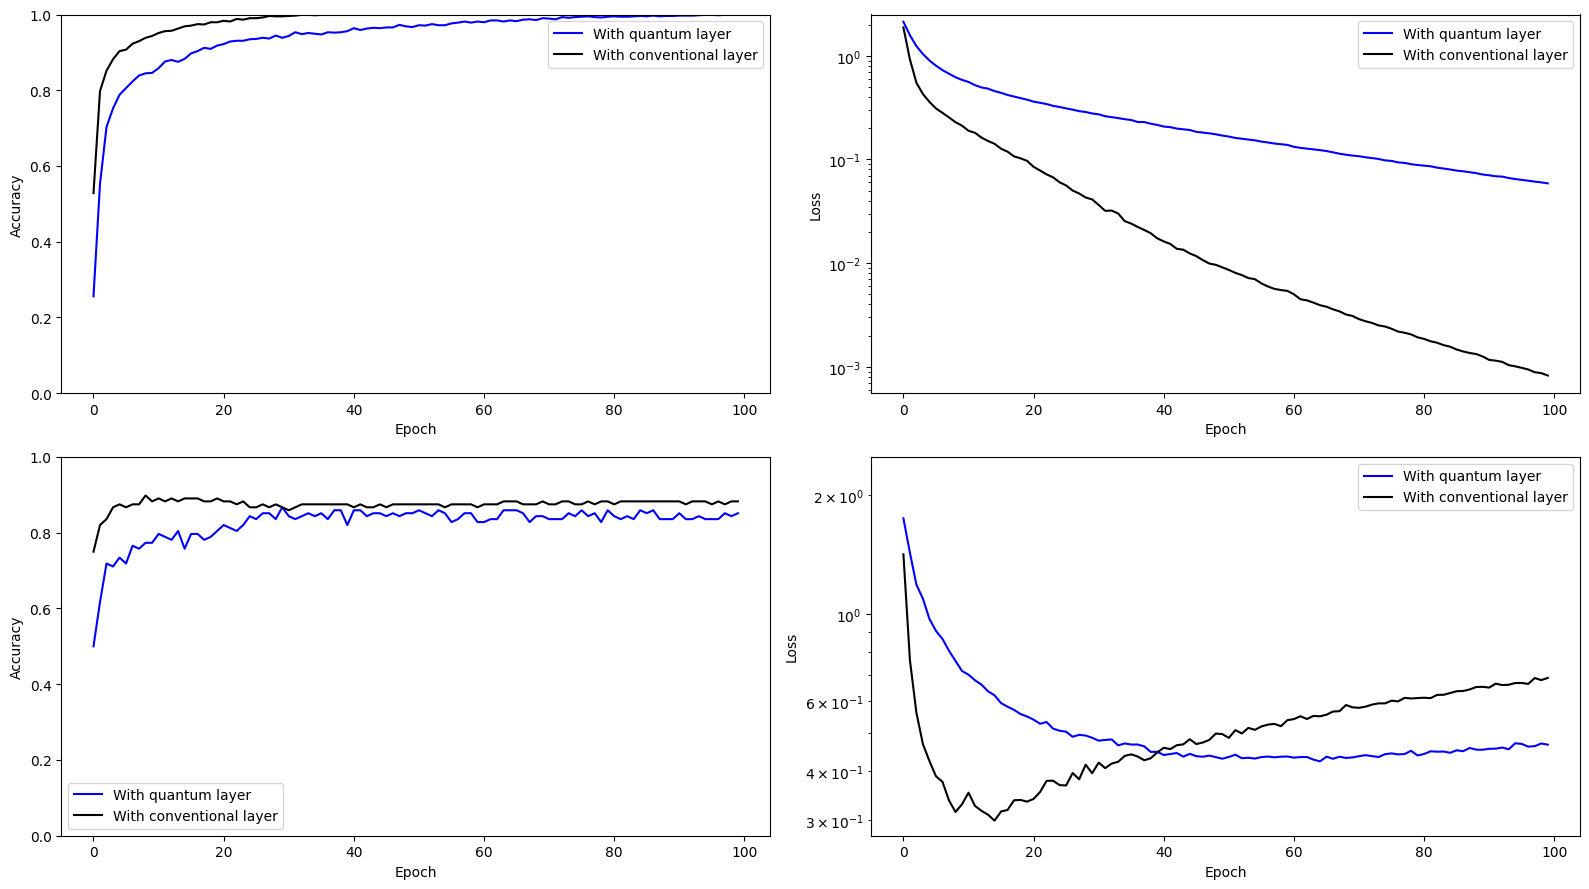

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))

ax1.plot(q_history.history["accuracy"], "-b", label="With quantum layer")
ax1.plot(c_history.history["accuracy"], "-k", label="With conventional layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["loss"], "-b", label="With quantum layer")
ax2.plot(c_history.history["loss"], "-k", label="With conventional layer")
ax2.set_yscale("log")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

ax3.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax3.plot(c_history.history["val_accuracy"], "-k", label="With conventional layer")
ax3.set_ylabel("Accuracy")
ax3.set_ylim([0, 1])
ax3.set_xlabel("Epoch")
ax3.legend()

ax4.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
ax4.plot(c_history.history["val_loss"], "-k", label="With conventional layer")
ax4.set_yscale("log")
ax4.set_ylabel("Loss")
ax4.set_ylim(top=2.5)
ax4.set_xlabel("Epoch")
ax4.legend()

plt.tight_layout()
plt.show()

## Discussion



The quanvolutional layer, trainable or not, only fared comparably to the classical convolutional layer in this demonstration. Due to the low depth of the circuit, it is not well-suited for capturing many features, or to deal with data augmentation such as slanted handwriting and variations of the same glyph.

Unfortunately, quanvolution is much more time-consuming than classical convolution even when augmented with GPU acceleration on both the training and the quantum simulation parts. However, the quanvolutional method may generalize more since the rise in loss with high epoch numbers is the result of generalization error.

In the future, we will examine adding more options to the quanvolutional network such as quanvoluting a multi-channel image, and even adding cross-channel quanvolutional circuits. A cross-channel quanvolutional circuit would have $LK^2$ qubits, with random circuits applying across qubits representing different channels. However, this option can make quantum simulation more expensive, so it will not be a scalable option.

Furthermore, we could make this deep neural network fully quantum by replacing the dense layers with variational circuits.